In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import torchvision.models as models


from dataloader import CustomImageDataset
from torch.utils.data import DataLoader, random_split
import random


In [40]:
# Define the transform
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # resize to 64x64
    # transforms.Grayscale(),
    transforms.ToTensor()
])

# Create the dataset and dataloader

class_to_idx = {'sma': 1, 'non-sma': 0}

# Get current directory
current_directory = os.getcwd()

# Relative directory of images
other_string = "Red_Cell_Morphology_binary_cells_balanced"
# Combine directpries
new_path = os.path.join(current_directory, other_string)

# Create dataset
dataset = CustomImageDataset(root_dir=new_path, class_to_idx=class_to_idx, transform=transform)

# Define the train, validation, and test ratios (e.g., 70%, 15%, 15%)
train_ratio = 0.7
val_ratio = 0.0
test_ratio = 0.3

# Calculate the number of samples for each split
num_samples = len(dataset)
train_samples = int(train_ratio * num_samples)
val_samples = int(val_ratio * num_samples)
test_samples = num_samples - train_samples - val_samples

# Use random_split to split the dataset
train_set, val_set, test_set = random_split(dataset, [train_samples, val_samples, test_samples])

# Create data loaders for each split
train_loader = DataLoader(train_set, batch_size=1, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1, shuffle=False)  # No need to shuffle validation set
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)  # No need to shuffle test set


In [41]:
# Get counts
counts = dataset.get_class_counts()
print(counts)

{'sma': 33, 'non-sma': 33}


Code that checks if the sample/bag has less than 20 RBC images and deleted the sample if they are less. This is not correct

In [14]:
new_dataset = []  # Initialize an empty list to store the filtered bags

for i, (images, label) in enumerate(dataset):
    if len(images) < 20:
        continue  # Skip the bag if the number of images is less than 20

    new_dataset.append((images, label))  # Add the bag to the new dataset if it meets the condition

    # Print information about the bag
    print(f"Bag ID: {len(new_dataset)}, Class: {'SMA' if label==1 else 'non-SMA'}, Number of images: {len(images)}")

dataset = new_dataset  # Update the dataset with the filtered bags


Bag ID: 1, Class: SMA, Number of images: 199
Bag ID: 2, Class: SMA, Number of images: 186


In [15]:
# Get counts
counts = dataset.get_class_counts()
print(counts)

AttributeError: 'list' object has no attribute 'get_class_counts'

In [16]:
# Fetch first bag from the DataLoader
images, label = next(iter(train_loader))

print(f"Class: {'SMA' if label.item()==1 else 'non-SMA'}, Number of images: {len(images)}")

# Display all images from this bag
fig = plt.figure(figsize=(20, 10))  # adjust size as needed
for i in range(len(images)):
    ax = fig.add_subplot(1, len(images), i+1, xticks=[], yticks=[])
    img = images[i].squeeze().permute(1, 2, 0)  
    ax.imshow(img.numpy())
plt.show()

Class: SMA, Number of images: 186


In [17]:
# Iterate through the data loader
for images, label in train_loader:
    # Iterate through each image in the bag
    for i in range(len(images[0])):
        print(f"Image {i+1} dimensions: {images[i].size()}")

Image 1 dimensions: torch.Size([1, 3, 64, 64])
Image 1 dimensions: torch.Size([1, 3, 64, 64])


In [18]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(4 * 64 * 64, 500)  # Adjusted for input image size 224x224
        self.fc2 = nn.Linear(500, 100)
        self.fc3 = nn.Linear(100, 1)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        # Perform individual feature extraction on each image
        features = []
        for img in x:
            img_features = self.pool(F.relu(self.conv1(img)))
            img_features = self.pool(F.relu(self.conv2(img_features)))            
            img_features = img_features.view(img_features.size(0), -1)  # Flatten layer
            img_features = F.relu(self.fc1(img_features))
            img_features = self.fc2(img_features)
            features.append(img_features)

        # Apply max pooling across all images
        pooled_features = torch.stack(features)
        # print(pooled_features.size())
        pooled_features, _ = torch.max(pooled_features, dim=0)
        # print(pooled_features.size())

        # Flatten the pooled features
        x = pooled_features.view(pooled_features.size(0), -1)

        x=F.relu(x)

        # Pass through the fully connected layers
        x = self.fc3(x)
        x = self.sigmoid(x)  # Apply sigmoid activation

        return x

In [43]:
class SimpleCNN1(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:6])  # Remove last fully connected layer

        # Freeze the ResNet-50 weights
        for param in self.features.parameters():
            param.requires_grad = False
        
        self.fc2 = nn.Linear(32768, 2048)
        self.fc3 = nn.Linear(2048, 1)  # Adjusted for ResNet-50 output size
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # print(type(x))
        imgs_features = []
        #idxs=random.sample(range(len(x)),k=50)
        # print(type(x))
        # print(x)
        #x=[x[i] for i in idxs]

        for img in x:
            img_features = self.features(img)
            img_features = img_features.view(img_features.size(0), -1)
            img_features=self.fc2(img_features)
            imgs_features.append(img_features)

        # Apply max pooling across all images
        pooled_features = torch.stack(imgs_features)
        pooled_features, _ = torch.max(pooled_features, dim=0)

        # Flatten the pooled features
        x = pooled_features.view(pooled_features.size(0), -1)

        # Pass through the fully connected layers
        x = self.fc3(x)
        x = self.sigmoid(x)  # Apply sigmoid activation

        return x


In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('This will run on', device)

This will run on cuda


In [47]:
# Initialize the network and optimizer
net = SimpleCNN1()

net.to(device) #Move model to GPU

loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=0.00001)

# Calculate class frequencies
# class_0_count = 110  # Number of samples in class 0
# class_1_count = 33  # Number of samples in class 1

# # Calculate class weights
# total_count = class_0_count + class_1_count
# class_0_weight = total_count / (2 * class_0_count)
# class_1_weight = total_count / (2 * class_1_count)

# weight=torch.tensor([class_1_weight])
# print(weight)

# Initialize lists to store accuracy values
train_accuracy_list = []
val_accuracy_list = []
test_accuracy = 0.0       
objective_tracker=[]

# Training loop
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(total=len(train_loader),desc=f'Epoch {epoch+1}/{1}', unit='batch',) as pbar:
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # print(len(inputs))
            # print(inputs[0].size()) # Len n images of size [1,3,224,224]
            # print(labels) # Tensor scalar
            
            
            # Move each tensor in the list to the GPU
            inputs = [tensor.to(device) for tensor in inputs]
            # inputs = inputs.to(device)
            labels = labels.to(device)

            net = net.to(device)
            
            target = net(inputs)
            print('actual label: ', labels)

            print('target: ', target)
            # target = torch.round(target,1)
            objective = loss(target[0],labels.float())
            optimizer.zero_grad()
            objective.backward()
            optimizer.step()
            objective_tracker.append(objective)

            # Update accuracy
            predicted = target.data.round().int()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # print statistics
            running_loss += objective.item()
            
             # Print loss in every minibatch
            # print(f'Epoch {epoch+1}/{1}, Minibatch {i+1}/{len(train_loader)}, Loss: {objective.item()}')
            pbar.update(1)

    # Calculate training accuracy
    train_accuracy = 100 * correct / total                                                                                      
    train_accuracy_list.append(train_accuracy)

#     # Validation accuracy
#     net.eval()  # Switch to evaluation mode                                                                                                                                                                     
#     val_correct = 0
#     val_total = 0

#     with torch.no_grad():
#         for data in val_loader:
#             inputs, labels = data
#             inputs = [tensor.to(device) for tensor in inputs]

#             target = net(inputs)
#             target = target.to(device)

#             labels = labels.to(device)

#             # Calculate validation accuracy
#             predicted = target.data.round().int()
#             val_total += labels.size(0)
#             val_correct += (predicted == labels).sum().item()

#     # val_accuracy = 100 * val_correct / val_total
#     # val_accuracy_list.append(val_accuracy)

 # Testing accuracy
net.eval()  # Switch to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs = [tensor.to(device) for tensor in inputs]

        target = net(inputs)
        target = target.to(device)
        labels = labels.to(device)

        # Calculate test accuracy
        predicted = target.data.round().int()
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total

print(f'Training Accuracy: {train_accuracy_list[-1]:.2f}%')
# print(f'Validation Accuracy: {val_accuracy_list[-1]:.2f}%')
print(f'Test Accuracy: {test_accuracy:.2f}%')

print('Finished Training')


Epoch 1/1:   2%|▏         | 1/46 [00:00<00:22,  2.02batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.5139]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.6322]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 1/1:   7%|▋         | 3/46 [00:00<00:12,  3.37batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.6653]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.6962]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 1/1:  11%|█         | 5/46 [00:02<00:18,  2.24batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.6673]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.6538]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 1/1:  13%|█▎        | 6/46 [00:03<00:24,  1.61batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.6327]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 1/1:  17%|█▋        | 8/46 [00:04<00:23,  1.62batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.5775]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 1/1:  20%|█▉        | 9/46 [00:04<00:22,  1.64batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.5437]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 1/1:  22%|██▏       | 10/46 [00:05<00:17,  2.09batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.4758]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.4445]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 1/1:  24%|██▍       | 11/46 [00:05<00:19,  1.78batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.4243]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 1/1:  28%|██▊       | 13/46 [00:07<00:21,  1.51batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.4358]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 1/1:  30%|███       | 14/46 [00:08<00:20,  1.56batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.4290]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.3888]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 1/1:  35%|███▍      | 16/46 [00:09<00:18,  1.66batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.3880]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.3770]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 1/1:  37%|███▋      | 17/46 [00:09<00:18,  1.60batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.3417]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 1/1:  41%|████▏     | 19/46 [00:11<00:16,  1.61batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.3164]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 1/1:  43%|████▎     | 20/46 [00:11<00:12,  2.07batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.2978]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.2914]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 1/1:  48%|████▊     | 22/46 [00:12<00:14,  1.69batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.3200]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.3051]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 1/1:  52%|█████▏    | 24/46 [00:13<00:10,  2.17batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.3343]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 1/1:  54%|█████▍    | 25/46 [00:13<00:09,  2.14batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.3124]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 1/1:  57%|█████▋    | 26/46 [00:14<00:09,  2.14batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.3190]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.3113]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 1/1:  59%|█████▊    | 27/46 [00:15<00:10,  1.80batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.3248]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 1/1:  61%|██████    | 28/46 [00:15<00:10,  1.75batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.3269]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 1/1:  65%|██████▌   | 30/46 [00:16<00:09,  1.74batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.2957]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.2808]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 1/1:  70%|██████▉   | 32/46 [00:18<00:08,  1.61batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.2319]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 1/1:  72%|███████▏  | 33/46 [00:18<00:07,  1.72batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.2379]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.1796]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 1/1:  76%|███████▌  | 35/46 [00:19<00:04,  2.60batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.1965]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1316]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 1/1:  80%|████████  | 37/46 [00:19<00:02,  3.53batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1682]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 1/1:  83%|████████▎ | 38/46 [00:19<00:02,  2.96batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1674]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1519]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 1/1:  87%|████████▋ | 40/46 [00:20<00:02,  2.47batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.1325]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 1/1:  89%|████████▉ | 41/46 [00:21<00:02,  2.32batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.1241]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 1/1:  91%|█████████▏| 42/46 [00:21<00:01,  2.27batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1107]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 1/1:  93%|█████████▎| 43/46 [00:22<00:01,  2.34batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0969]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 1/1:  96%|█████████▌| 44/46 [00:22<00:00,  2.40batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.1031]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 1/1:  98%|█████████▊| 45/46 [00:23<00:00,  2.23batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0879]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 1/1: 100%|██████████| 46/46 [00:23<00:00,  1.95batch/s]


actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.0843]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 2/1:   2%|▏         | 1/46 [00:00<00:17,  2.59batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0629]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 2/1:   4%|▍         | 2/46 [00:00<00:19,  2.26batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.1245]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 2/1:   7%|▋         | 3/46 [00:01<00:17,  2.40batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.0860]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0342]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 2/1:   9%|▊         | 4/46 [00:02<00:23,  1.79batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0378]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 2/1:  13%|█▎        | 6/46 [00:03<00:23,  1.67batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.1115]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 2/1:  15%|█▌        | 7/46 [00:03<00:23,  1.67batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0303]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 2/1:  17%|█▋        | 8/46 [00:04<00:22,  1.65batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0339]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 2/1:  20%|█▉        | 9/46 [00:04<00:18,  1.97batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.0939]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0261]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 2/1:  24%|██▍       | 11/46 [00:05<00:18,  1.91batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.0821]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 2/1:  26%|██▌       | 12/46 [00:06<00:15,  2.13batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.0907]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0277]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 2/1:  30%|███       | 14/46 [00:07<00:18,  1.69batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0327]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 2/1:  33%|███▎      | 15/46 [00:08<00:17,  1.76batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.1034]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 2/1:  35%|███▍      | 16/46 [00:08<00:15,  1.93batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.1258]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 2/1:  37%|███▋      | 17/46 [00:09<00:15,  1.92batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0643]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.1101]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 2/1:  41%|████▏     | 19/46 [00:09<00:11,  2.36batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0413]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.1536]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 2/1:  46%|████▌     | 21/46 [00:11<00:12,  1.99batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.2188]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0569]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 2/1:  50%|█████     | 23/46 [00:12<00:13,  1.65batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0735]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 2/1:  52%|█████▏    | 24/46 [00:13<00:12,  1.69batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0759]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 2/1:  54%|█████▍    | 25/46 [00:13<00:10,  2.04batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0798]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0215]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 2/1:  59%|█████▊    | 27/46 [00:13<00:07,  2.62batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.2112]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.2093]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 2/1:  63%|██████▎   | 29/46 [00:15<00:08,  1.90batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1164]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0961]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 2/1:  67%|██████▋   | 31/46 [00:16<00:07,  1.93batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.2890]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.2849]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 2/1:  72%|███████▏  | 33/46 [00:17<00:06,  1.91batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.3013]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.3171]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 2/1:  76%|███████▌  | 35/46 [00:18<00:05,  1.85batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1980]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.2079]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 2/1:  78%|███████▊  | 36/46 [00:19<00:05,  1.69batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.4379]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 2/1:  80%|████████  | 37/46 [00:20<00:05,  1.67batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1990]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 2/1:  83%|████████▎ | 38/46 [00:20<00:05,  1.56batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.2042]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 2/1:  85%|████████▍ | 39/46 [00:21<00:04,  1.54batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.4648]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 2/1:  89%|████████▉ | 41/46 [00:22<00:03,  1.62batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.4928]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 2/1:  91%|█████████▏| 42/46 [00:23<00:02,  1.87batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.5326]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 2/1:  93%|█████████▎| 43/46 [00:23<00:01,  2.38batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.5601]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1945]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.2392]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 2/1: 100%|██████████| 46/46 [00:23<00:00,  1.96batch/s]


actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.6625]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 3/1:   2%|▏         | 1/46 [00:00<00:13,  3.37batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.7187]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 3/1:   4%|▍         | 2/46 [00:00<00:18,  2.40batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.7989]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 3/1:   7%|▋         | 3/46 [00:01<00:16,  2.63batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.7707]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.4753]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 3/1:  11%|█         | 5/46 [00:02<00:19,  2.14batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8482]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 3/1:  13%|█▎        | 6/46 [00:02<00:18,  2.19batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8850]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 3/1:  15%|█▌        | 7/46 [00:03<00:19,  2.02batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.5361]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 3/1:  17%|█▋        | 8/46 [00:03<00:19,  2.00batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8352]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8635]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 3/1:  22%|██▏       | 10/46 [00:04<00:19,  1.84batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.5195]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.4671]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 3/1:  26%|██▌       | 12/46 [00:06<00:19,  1.71batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8297]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1648]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 3/1:  30%|███       | 14/46 [00:06<00:13,  2.32batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.3581]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 3/1:  33%|███▎      | 15/46 [00:07<00:14,  2.14batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.2788]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 3/1:  35%|███▍      | 16/46 [00:07<00:13,  2.29batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.7227]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 3/1:  37%|███▋      | 17/46 [00:07<00:10,  2.72batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.6622]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 3/1:  39%|███▉      | 18/46 [00:08<00:10,  2.69batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.6020]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 3/1:  41%|████▏     | 19/46 [00:08<00:09,  2.83batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.5304]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 3/1:  43%|████▎     | 20/46 [00:08<00:10,  2.57batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.5950]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 3/1:  46%|████▌     | 21/46 [00:09<00:10,  2.36batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.2132]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 3/1:  48%|████▊     | 22/46 [00:09<00:10,  2.27batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.6911]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.6601]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 3/1:  50%|█████     | 23/46 [00:10<00:11,  2.04batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1939]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 3/1:  52%|█████▏    | 24/46 [00:11<00:13,  1.61batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1722]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 3/1:  54%|█████▍    | 25/46 [00:12<00:13,  1.52batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.5954]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 3/1:  57%|█████▋    | 26/46 [00:13<00:15,  1.29batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.6653]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 3/1:  59%|█████▊    | 27/46 [00:13<00:13,  1.38batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.2342]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 3/1:  63%|██████▎   | 29/46 [00:15<00:10,  1.63batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.2210]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.2193]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 3/1:  67%|██████▋   | 31/46 [00:15<00:07,  1.96batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.6724]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1373]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 3/1:  72%|███████▏  | 33/46 [00:17<00:06,  1.91batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.2168]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0404]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 3/1:  76%|███████▌  | 35/46 [00:17<00:04,  2.67batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.4478]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1591]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 3/1:  80%|████████  | 37/46 [00:18<00:04,  2.04batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1056]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0406]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.4180]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 3/1:  87%|████████▋ | 40/46 [00:20<00:02,  2.06batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.3678]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0834]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 3/1:  91%|█████████▏| 42/46 [00:21<00:02,  1.83batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1341]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 3/1:  93%|█████████▎| 43/46 [00:21<00:01,  1.97batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1194]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.2654]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.3142]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 3/1: 100%|██████████| 46/46 [00:23<00:00,  1.98batch/s]


actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1063]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 4/1:   2%|▏         | 1/46 [00:00<00:14,  3.18batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.4308]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 4/1:   4%|▍         | 2/46 [00:00<00:18,  2.38batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.4771]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.5477]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 4/1:   7%|▋         | 3/46 [00:01<00:21,  1.97batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.5785]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 4/1:  11%|█         | 5/46 [00:02<00:21,  1.88batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.5774]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0199]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1120]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 4/1:  17%|█▋        | 8/46 [00:03<00:17,  2.15batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.7106]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.7080]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 4/1:  22%|██▏       | 10/46 [00:04<00:14,  2.43batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8604]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 4/1:  24%|██▍       | 11/46 [00:04<00:13,  2.55batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8113]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 4/1:  26%|██▌       | 12/46 [00:05<00:13,  2.53batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.4481]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8718]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 4/1:  28%|██▊       | 13/46 [00:06<00:19,  1.73batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9081]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 4/1:  33%|███▎      | 15/46 [00:07<00:15,  1.98batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8895]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 4/1:  35%|███▍      | 16/46 [00:07<00:14,  2.06batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9221]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 4/1:  37%|███▋      | 17/46 [00:08<00:14,  1.96batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.4341]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.3461]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 4/1:  39%|███▉      | 18/46 [00:08<00:15,  1.85batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.4333]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 4/1:  41%|████▏     | 19/46 [00:09<00:16,  1.64batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9115]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 4/1:  46%|████▌     | 21/46 [00:11<00:15,  1.57batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.3849]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 4/1:  48%|████▊     | 22/46 [00:11<00:14,  1.68batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9105]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8510]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0881]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1627]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 4/1:  54%|█████▍    | 25/46 [00:12<00:08,  2.36batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1963]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 4/1:  59%|█████▊    | 27/46 [00:13<00:10,  1.88batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.2687]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1547]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 4/1:  61%|██████    | 28/46 [00:14<00:10,  1.71batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0513]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0873]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 4/1:  67%|██████▋   | 31/46 [00:15<00:07,  2.01batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.4149]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 4/1:  70%|██████▉   | 32/46 [00:16<00:06,  2.13batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.4586]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 4/1:  72%|███████▏  | 33/46 [00:16<00:05,  2.27batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.4565]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0348]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 4/1:  76%|███████▌  | 35/46 [00:17<00:05,  1.97batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0287]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 4/1:  78%|███████▊  | 36/46 [00:18<00:05,  1.86batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.4122]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 4/1:  80%|████████  | 37/46 [00:18<00:04,  1.93batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.3820]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 4/1:  83%|████████▎ | 38/46 [00:19<00:03,  2.38batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.4400]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 4/1:  85%|████████▍ | 39/46 [00:19<00:03,  2.12batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0653]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 4/1:  87%|████████▋ | 40/46 [00:19<00:02,  2.48batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0478]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0514]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 4/1:  89%|████████▉ | 41/46 [00:20<00:02,  1.77batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0940]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 4/1:  93%|█████████▎| 43/46 [00:22<00:01,  1.71batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0783]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 4/1:  96%|█████████▌| 44/46 [00:22<00:01,  1.81batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.5315]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 4/1:  98%|█████████▊| 45/46 [00:23<00:00,  1.76batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1200]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 4/1: 100%|██████████| 46/46 [00:23<00:00,  1.94batch/s]


actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0872]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 5/1:   2%|▏         | 1/46 [00:00<00:27,  1.65batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.6636]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0312]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 5/1:   7%|▋         | 3/46 [00:01<00:25,  1.72batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0596]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0541]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 5/1:   9%|▊         | 4/46 [00:02<00:30,  1.37batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0602]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 5/1:  11%|█         | 5/46 [00:03<00:30,  1.37batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.5217]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 5/1:  15%|█▌        | 7/46 [00:04<00:24,  1.59batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.6444]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 5/1:  17%|█▋        | 8/46 [00:04<00:20,  1.90batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.6877]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 5/1:  20%|█▉        | 9/46 [00:05<00:15,  2.43batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.7353]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1028]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 5/1:  22%|██▏       | 10/46 [00:05<00:17,  2.07batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0812]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 5/1:  26%|██▌       | 12/46 [00:06<00:15,  2.13batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.6951]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 5/1:  28%|██▊       | 13/46 [00:06<00:12,  2.63batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8158]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 5/1:  30%|███       | 14/46 [00:07<00:13,  2.30batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1702]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1101]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 5/1:  33%|███▎      | 15/46 [00:08<00:16,  1.91batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8548]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 5/1:  37%|███▋      | 17/46 [00:09<00:15,  1.91batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8021]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0279]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 5/1:  41%|████▏     | 19/46 [00:09<00:10,  2.52batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1248]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 5/1:  43%|████▎     | 20/46 [00:09<00:09,  2.79batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1483]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0763]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1968]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 5/1:  48%|████▊     | 22/46 [00:10<00:08,  2.82batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1074]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 5/1:  50%|█████     | 23/46 [00:11<00:10,  2.11batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0715]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 5/1:  52%|█████▏    | 24/46 [00:12<00:11,  1.85batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.7302]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 5/1:  57%|█████▋    | 26/46 [00:13<00:10,  1.88batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.7679]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.6566]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 5/1:  61%|██████    | 28/46 [00:14<00:11,  1.58batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0589]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.7318]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 5/1:  65%|██████▌   | 30/46 [00:15<00:07,  2.15batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1211]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 5/1:  67%|██████▋   | 31/46 [00:15<00:07,  2.10batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.7322]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 5/1:  70%|██████▉   | 32/46 [00:16<00:07,  2.00batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0401]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 5/1:  72%|███████▏  | 33/46 [00:16<00:06,  2.05batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1232]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 5/1:  74%|███████▍  | 34/46 [00:17<00:06,  1.95batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1511]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 5/1:  76%|███████▌  | 35/46 [00:17<00:05,  2.15batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.7952]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 5/1:  78%|███████▊  | 36/46 [00:18<00:04,  2.02batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0597]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 5/1:  80%|████████  | 37/46 [00:18<00:04,  2.16batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.7770]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.7821]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 5/1:  85%|████████▍ | 39/46 [00:20<00:03,  1.91batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.7616]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 5/1:  87%|████████▋ | 40/46 [00:20<00:02,  2.10batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.7798]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 5/1:  89%|████████▉ | 41/46 [00:20<00:02,  2.10batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8088]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0320]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.7713]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 5/1:  96%|█████████▌| 44/46 [00:22<00:00,  2.26batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1915]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 5/1:  98%|█████████▊| 45/46 [00:22<00:00,  2.49batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.7918]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 5/1: 100%|██████████| 46/46 [00:22<00:00,  2.01batch/s]


actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8311]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 6/1:   0%|          | 0/46 [00:00<?, ?batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1831]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 6/1:   4%|▍         | 2/46 [00:00<00:17,  2.55batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9286]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 6/1:   7%|▋         | 3/46 [00:01<00:21,  2.03batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.2324]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 6/1:   9%|▊         | 4/46 [00:01<00:18,  2.29batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9300]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8859]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 6/1:  13%|█▎        | 6/46 [00:02<00:15,  2.58batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9369]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 6/1:  15%|█▌        | 7/46 [00:03<00:17,  2.18batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1196]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 6/1:  17%|█▋        | 8/46 [00:03<00:15,  2.42batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9316]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 6/1:  20%|█▉        | 9/46 [00:04<00:17,  2.12batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9334]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1440]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 6/1:  24%|██▍       | 11/46 [00:05<00:16,  2.08batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8725]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 6/1:  26%|██▌       | 12/46 [00:05<00:16,  2.09batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1829]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 6/1:  28%|██▊       | 13/46 [00:06<00:16,  2.03batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1817]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1110]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 6/1:  33%|███▎      | 15/46 [00:07<00:18,  1.71batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8901]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 6/1:  35%|███▍      | 16/46 [00:08<00:16,  1.79batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8457]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 6/1:  37%|███▋      | 17/46 [00:08<00:15,  1.86batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8699]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 6/1:  39%|███▉      | 18/46 [00:09<00:15,  1.79batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8679]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0205]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 6/1:  43%|████▎     | 20/46 [00:09<00:10,  2.49batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8027]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0933]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 6/1:  48%|████▊     | 22/46 [00:10<00:11,  2.10batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8425]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8806]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0471]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1325]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 6/1:  54%|█████▍    | 25/46 [00:11<00:07,  2.89batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1099]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 6/1:  59%|█████▊    | 27/46 [00:12<00:07,  2.41batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8722]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 6/1:  61%|██████    | 28/46 [00:13<00:07,  2.31batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8579]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0885]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 6/1:  63%|██████▎   | 29/46 [00:14<00:09,  1.78batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0570]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 6/1:  67%|██████▋   | 31/46 [00:15<00:08,  1.84batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.7908]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 6/1:  70%|██████▉   | 32/46 [00:15<00:07,  1.87batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0583]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 6/1:  72%|███████▏  | 33/46 [00:15<00:05,  2.22batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0673]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0506]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 6/1:  74%|███████▍  | 34/46 [00:16<00:06,  1.76batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0201]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.7334]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 6/1:  80%|████████  | 37/46 [00:18<00:05,  1.79batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0299]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 6/1:  83%|████████▎ | 38/46 [00:18<00:04,  1.79batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0477]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8143]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 6/1:  87%|████████▋ | 40/46 [00:20<00:03,  1.81batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8001]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 6/1:  89%|████████▉ | 41/46 [00:20<00:02,  1.83batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0705]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.7509]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 6/1:  91%|█████████▏| 42/46 [00:21<00:02,  1.74batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.7430]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 6/1:  96%|█████████▌| 44/46 [00:22<00:01,  1.78batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0843]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 6/1:  98%|█████████▊| 45/46 [00:22<00:00,  1.87batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8391]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 6/1: 100%|██████████| 46/46 [00:23<00:00,  1.95batch/s]


actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1175]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 7/1:   0%|          | 0/46 [00:00<?, ?batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0229]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0345]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 7/1:   7%|▋         | 3/46 [00:00<00:09,  4.51batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8871]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 7/1:   9%|▊         | 4/46 [00:00<00:08,  4.93batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8996]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0553]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 7/1:  13%|█▎        | 6/46 [00:02<00:18,  2.22batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0832]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 7/1:  15%|█▌        | 7/46 [00:02<00:19,  2.04batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0412]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 7/1:  17%|█▋        | 8/46 [00:03<00:18,  2.05batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8685]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8964]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 7/1:  22%|██▏       | 10/46 [00:04<00:18,  1.93batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8910]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8738]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 7/1:  26%|██▌       | 12/46 [00:05<00:20,  1.70batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0968]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 7/1:  28%|██▊       | 13/46 [00:06<00:18,  1.76batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8985]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 7/1:  30%|███       | 14/46 [00:06<00:16,  1.95batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9188]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 7/1:  33%|███▎      | 15/46 [00:07<00:14,  2.10batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9247]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9339]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 7/1:  37%|███▋      | 17/46 [00:08<00:15,  1.86batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9278]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 7/1:  39%|███▉      | 18/46 [00:08<00:13,  2.10batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9182]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9022]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 7/1:  43%|████▎     | 20/46 [00:09<00:13,  1.91batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1733]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 7/1:  46%|████▌     | 21/46 [00:10<00:12,  2.01batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9272]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 7/1:  48%|████▊     | 22/46 [00:10<00:11,  2.01batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9507]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9586]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9393]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 7/1:  52%|█████▏    | 24/46 [00:11<00:09,  2.24batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1369]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 7/1:  54%|█████▍    | 25/46 [00:12<00:11,  1.82batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1474]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 7/1:  57%|█████▋    | 26/46 [00:13<00:12,  1.55batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1657]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 7/1:  61%|██████    | 28/46 [00:14<00:12,  1.45batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0972]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 7/1:  63%|██████▎   | 29/46 [00:15<00:09,  1.72batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9398]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 7/1:  65%|██████▌   | 30/46 [00:15<00:08,  1.81batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9314]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 7/1:  67%|██████▋   | 31/46 [00:15<00:06,  2.25batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9268]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 7/1:  70%|██████▉   | 32/46 [00:16<00:06,  2.16batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1137]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0751]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 7/1:  74%|███████▍  | 34/46 [00:17<00:06,  1.84batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0641]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8721]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 7/1:  78%|███████▊  | 36/46 [00:18<00:05,  1.95batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8807]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 7/1:  80%|████████  | 37/46 [00:19<00:04,  1.83batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0862]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 7/1:  83%|████████▎ | 38/46 [00:19<00:04,  1.86batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0564]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 7/1:  85%|████████▍ | 39/46 [00:20<00:03,  2.21batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0463]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0638]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 7/1:  87%|████████▋ | 40/46 [00:20<00:03,  1.94batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0444]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 7/1:  91%|█████████▏| 42/46 [00:22<00:02,  1.72batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0327]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0355]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 7/1:  93%|█████████▎| 43/46 [00:22<00:01,  1.58batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0286]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 7/1:  96%|█████████▌| 44/46 [00:23<00:01,  1.54batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0056]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 7/1: 100%|██████████| 46/46 [00:23<00:00,  1.94batch/s]


actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.5682]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 8/1:   2%|▏         | 1/46 [00:00<00:27,  1.65batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0227]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 8/1:   4%|▍         | 2/46 [00:00<00:15,  2.79batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.7051]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 8/1:   7%|▋         | 3/46 [00:01<00:20,  2.09batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.7187]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 8/1:   9%|▊         | 4/46 [00:01<00:17,  2.41batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.7217]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 8/1:  11%|█         | 5/46 [00:02<00:16,  2.42batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.7743]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.7200]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 8/1:  15%|█▌        | 7/46 [00:03<00:18,  2.17batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.7700]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0240]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 8/1:  17%|█▋        | 8/46 [00:04<00:23,  1.64batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0119]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0615]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 8/1:  22%|██▏       | 10/46 [00:04<00:17,  2.06batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9246]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 8/1:  26%|██▌       | 12/46 [00:05<00:14,  2.42batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0386]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 8/1:  28%|██▊       | 13/46 [00:05<00:14,  2.31batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9181]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 8/1:  30%|███       | 14/46 [00:06<00:15,  2.11batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0937]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 8/1:  33%|███▎      | 15/46 [00:07<00:14,  2.09batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0943]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 8/1:  35%|███▍      | 16/46 [00:07<00:15,  1.96batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0934]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0715]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 8/1:  39%|███▉      | 18/46 [00:09<00:16,  1.74batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9430]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1014]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 8/1:  41%|████▏     | 19/46 [00:09<00:16,  1.59batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0605]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 8/1:  43%|████▎     | 20/46 [00:10<00:17,  1.47batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8674]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 8/1:  48%|████▊     | 22/46 [00:11<00:12,  1.90batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9324]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0423]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 8/1:  52%|█████▏    | 24/46 [00:12<00:13,  1.65batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0678]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 8/1:  54%|█████▍    | 25/46 [00:13<00:11,  1.87batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9076]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 8/1:  57%|█████▋    | 26/46 [00:13<00:10,  1.88batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8971]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 8/1:  59%|█████▊    | 27/46 [00:14<00:10,  1.80batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8995]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 8/1:  61%|██████    | 28/46 [00:14<00:10,  1.74batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0319]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 8/1:  63%|██████▎   | 29/46 [00:15<00:09,  1.85batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8993]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 8/1:  65%|██████▌   | 30/46 [00:15<00:08,  1.96batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8640]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 8/1:  67%|██████▋   | 31/46 [00:16<00:07,  2.08batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0648]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 8/1:  70%|██████▉   | 32/46 [00:16<00:06,  2.03batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9020]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 8/1:  72%|███████▏  | 33/46 [00:17<00:05,  2.21batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8964]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 8/1:  74%|███████▍  | 34/46 [00:17<00:05,  2.13batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9128]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0568]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 8/1:  76%|███████▌  | 35/46 [00:18<00:06,  1.80batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9320]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 8/1:  78%|███████▊  | 36/46 [00:19<00:06,  1.60batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0272]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0780]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 8/1:  85%|████████▍ | 39/46 [00:20<00:03,  2.19batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9221]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 8/1:  87%|████████▋ | 40/46 [00:20<00:02,  2.08batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0826]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9135]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 8/1:  91%|█████████▏| 42/46 [00:22<00:02,  1.65batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0622]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1167]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 8/1:  93%|█████████▎| 43/46 [00:22<00:01,  1.61batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0852]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 8/1:  98%|█████████▊| 45/46 [00:24<00:00,  1.65batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9110]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0327]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 9/1:   2%|▏         | 1/46 [00:00<00:24,  1.85batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9133]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0336]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 9/1:   7%|▋         | 3/46 [00:02<00:29,  1.47batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0415]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0295]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 9/1:   9%|▊         | 4/46 [00:02<00:30,  1.39batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0285]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 9/1:  13%|█▎        | 6/46 [00:03<00:21,  1.82batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9077]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 9/1:  15%|█▌        | 7/46 [00:04<00:20,  1.86batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8659]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8568]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 9/1:  17%|█▋        | 8/46 [00:04<00:21,  1.76batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0432]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 9/1:  22%|██▏       | 10/46 [00:06<00:20,  1.77batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8809]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 9/1:  24%|██▍       | 11/46 [00:06<00:17,  1.95batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9093]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 9/1:  26%|██▌       | 12/46 [00:07<00:18,  1.85batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0339]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0193]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 9/1:  30%|███       | 14/46 [00:07<00:12,  2.53batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0357]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 9/1:  33%|███▎      | 15/46 [00:07<00:11,  2.70batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9057]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 9/1:  35%|███▍      | 16/46 [00:08<00:12,  2.43batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0388]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 9/1:  37%|███▋      | 17/46 [00:08<00:13,  2.21batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0351]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 9/1:  39%|███▉      | 18/46 [00:09<00:13,  2.01batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0207]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9155]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0098]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0304]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 9/1:  48%|████▊     | 22/46 [00:10<00:07,  3.11batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8872]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 9/1:  50%|█████     | 23/46 [00:10<00:08,  2.81batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0324]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 9/1:  52%|█████▏    | 24/46 [00:11<00:07,  2.76batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8946]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 9/1:  54%|█████▍    | 25/46 [00:11<00:09,  2.33batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9107]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8378]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 9/1:  59%|█████▊    | 27/46 [00:12<00:08,  2.22batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9025]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9158]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 9/1:  63%|██████▎   | 29/46 [00:13<00:07,  2.31batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9334]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9115]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 9/1:  67%|██████▋   | 31/46 [00:15<00:08,  1.67batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0979]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0762]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 9/1:  70%|██████▉   | 32/46 [00:16<00:08,  1.61batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0698]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 9/1:  72%|███████▏  | 33/46 [00:16<00:08,  1.57batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0225]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 9/1:  76%|███████▌  | 35/46 [00:17<00:04,  2.21batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9229]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 9/1:  78%|███████▊  | 36/46 [00:17<00:04,  2.16batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9382]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 9/1:  80%|████████  | 37/46 [00:18<00:04,  2.00batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0400]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 9/1:  83%|████████▎ | 38/46 [00:18<00:04,  1.89batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9409]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0704]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 9/1:  85%|████████▍ | 39/46 [00:19<00:04,  1.70batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0526]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 9/1:  89%|████████▉ | 41/46 [00:20<00:02,  1.68batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9300]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0424]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 9/1:  93%|█████████▎| 43/46 [00:22<00:01,  1.59batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0425]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 9/1:  96%|█████████▌| 44/46 [00:22<00:01,  1.68batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9248]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9169]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 9/1: 100%|██████████| 46/46 [00:23<00:00,  1.92batch/s]


actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9416]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 10/1:   0%|          | 0/46 [00:00<?, ?batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0615]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 10/1:   4%|▍         | 2/46 [00:01<00:26,  1.69batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0506]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 10/1:   7%|▋         | 3/46 [00:01<00:24,  1.77batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0327]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0141]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 10/1:  11%|█         | 5/46 [00:02<00:17,  2.36batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0235]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 10/1:  13%|█▎        | 6/46 [00:02<00:17,  2.23batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9249]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 10/1:  15%|█▌        | 7/46 [00:03<00:14,  2.74batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9334]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0330]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 10/1:  22%|██▏       | 10/46 [00:03<00:10,  3.28batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0180]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9325]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0324]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 10/1:  24%|██▍       | 11/46 [00:04<00:14,  2.49batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0232]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 10/1:  26%|██▌       | 12/46 [00:05<00:18,  1.83batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0199]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 10/1:  30%|███       | 14/46 [00:07<00:19,  1.60batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0388]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 10/1:  33%|███▎      | 15/46 [00:07<00:19,  1.61batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0271]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 10/1:  35%|███▍      | 16/46 [00:08<00:17,  1.71batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8790]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 10/1:  37%|███▋      | 17/46 [00:08<00:16,  1.75batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8801]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8369]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 10/1:  41%|████▏     | 19/46 [00:09<00:14,  1.91batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8781]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.8849]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 10/1:  43%|████▎     | 20/46 [00:10<00:15,  1.67batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0246]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 10/1:  46%|████▌     | 21/46 [00:11<00:16,  1.52batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9437]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 10/1:  50%|█████     | 23/46 [00:11<00:10,  2.26batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9228]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9123]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 10/1:  54%|█████▍    | 25/46 [00:13<00:11,  1.75batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9310]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 10/1:  57%|█████▋    | 26/46 [00:13<00:11,  1.78batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0450]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 10/1:  59%|█████▊    | 27/46 [00:14<00:11,  1.72batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9591]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 10/1:  61%|██████    | 28/46 [00:14<00:09,  1.82batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0582]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 10/1:  63%|██████▎   | 29/46 [00:15<00:08,  2.08batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9635]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 10/1:  65%|██████▌   | 30/46 [00:15<00:07,  2.20batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9679]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 10/1:  67%|██████▋   | 31/46 [00:16<00:06,  2.17batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9613]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 10/1:  70%|██████▉   | 32/46 [00:16<00:05,  2.41batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9689]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 10/1:  72%|███████▏  | 33/46 [00:17<00:06,  2.09batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9607]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 10/1:  74%|███████▍  | 34/46 [00:17<00:05,  2.06batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9650]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 10/1:  76%|███████▌  | 35/46 [00:18<00:05,  1.91batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9677]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0762]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 10/1:  80%|████████  | 37/46 [00:19<00:05,  1.55batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0592]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 10/1:  83%|████████▎ | 38/46 [00:20<00:04,  1.61batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.1011]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0868]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 10/1:  87%|████████▋ | 40/46 [00:21<00:03,  1.73batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0899]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 10/1:  89%|████████▉ | 41/46 [00:21<00:02,  1.91batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9665]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 10/1:  91%|█████████▏| 42/46 [00:22<00:01,  2.26batch/s]

actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0628]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0477]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 10/1:  93%|█████████▎| 43/46 [00:22<00:01,  1.84batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9491]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Epoch 10/1: 100%|██████████| 46/46 [00:24<00:00,  1.91batch/s]

actual label:  tensor([1], device='cuda:0')
target:  tensor([[0.9224]], device='cuda:0', grad_fn=<SigmoidBackward0>)
actual label:  tensor([0], device='cuda:0')
target:  tensor([[0.0128]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Training Accuracy: 100.00%
Test Accuracy: 60.00%
Finished Training


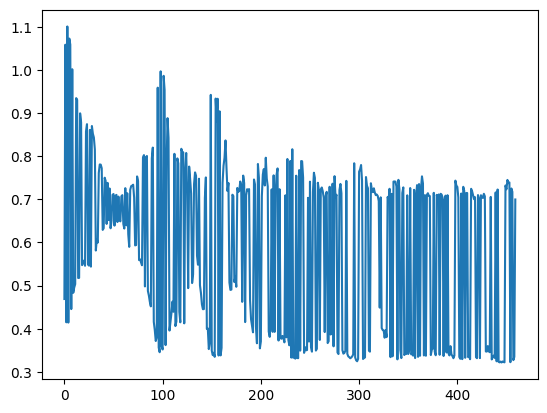

In [48]:
# Plot the loss

obj=[]

for i in range(len(objective_tracker)):
    obj.append(objective_tracker[i].item())

plt.plot(obj)


In [32]:
test_total=0
test_correct=0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        target = net(inputs)
        print('target', target)
        print('labels: ', labels)

        # Calculate test accuracy
        print('target data:' , target.data)
        predicted = target.data.round().int()
        print('predicted', predicted)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(test_accuracy)

target tensor([[0.8240]])
labels:  tensor([1])
target data: tensor([[0.8240]])
predicted tensor([[1]], dtype=torch.int32)
target tensor([[0.8167]])
labels:  tensor([1])
target data: tensor([[0.8167]])
predicted tensor([[1]], dtype=torch.int32)
target tensor([[0.8113]])
labels:  tensor([1])
target data: tensor([[0.8113]])
predicted tensor([[1]], dtype=torch.int32)
target tensor([[0.8184]])
labels:  tensor([1])
target data: tensor([[0.8184]])
predicted tensor([[1]], dtype=torch.int32)
target tensor([[0.8050]])
labels:  tensor([1])
target data: tensor([[0.8050]])
predicted tensor([[1]], dtype=torch.int32)
target tensor([[0.8205]])
labels:  tensor([1])
target data: tensor([[0.8205]])
predicted tensor([[1]], dtype=torch.int32)
100.0
